In [146]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


TensorShape([50, 50])

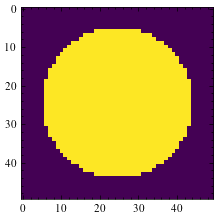

In [147]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


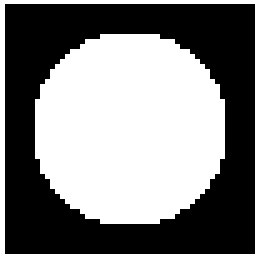

In [148]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


In [149]:
import matplotlib.patches as mpatches


w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(0))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(0))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  

#w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


x = img




directory = f"figures/malus"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()

x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 


x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

init_mag = tf.math.reduce_euclidean_norm(x).numpy()

angles = np.linspace(-np.pi, np.pi, 100)

for i in range(100):
	print(i)
	print(x.shape)
	#fig, ax = plt.subplots()

	w[:,:,0,0] = (np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
	w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  

		
	x_out = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(response_mag[-1])

	'''im = ax.imshow(np.sum(x_out[0,:,:,:], axis=-1));
	#ax.plot(45//2, 45, marker = '+', color='red');



	ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

	fig.colorbar(im, orientation='vertical');
	fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')'''




0
(1, 50, 50, 1)
1.0281652
1
(1, 50, 50, 1)
1.0264488
2
(1, 50, 50, 1)
1.0213101
3
(1, 50, 50, 1)
1.0127805
4
(1, 50, 50, 1)
1.0009133
5
(1, 50, 50, 1)
0.9857971
6
(1, 50, 50, 1)
0.9675382
7
(1, 50, 50, 1)
0.94625807
8
(1, 50, 50, 1)
0.92210245
9
(1, 50, 50, 1)
0.8952448
10
(1, 50, 50, 1)
0.8658924
11
(1, 50, 50, 1)
0.8342951
12
(1, 50, 50, 1)
0.80072755
13
(1, 50, 50, 1)
0.7655216
14
(1, 50, 50, 1)
0.7291027
15
(1, 50, 50, 1)
0.6919178
16
(1, 50, 50, 1)
0.654504
17
(1, 50, 50, 1)
0.617583
18
(1, 50, 50, 1)
0.5819125
19
(1, 50, 50, 1)
0.5483446
20
(1, 50, 50, 1)
0.51790303
21
(1, 50, 50, 1)
0.4917862
22
(1, 50, 50, 1)
0.47105664
23
(1, 50, 50, 1)
0.45673814
24
(1, 50, 50, 1)
0.44979563
25
(1, 50, 50, 1)
0.4507325
26
(1, 50, 50, 1)
0.4592513
27
(1, 50, 50, 1)
0.47472775
28
(1, 50, 50, 1)
0.49640158
29
(1, 50, 50, 1)
0.52318084
30
(1, 50, 50, 1)
0.55385804
31
(1, 50, 50, 1)
0.5873384
32
(1, 50, 50, 1)
0.622757
33
(1, 50, 50, 1)
0.6592654
34
(1, 50, 50, 1)
0.69614094
35
(1, 50, 50, 1)
0.7

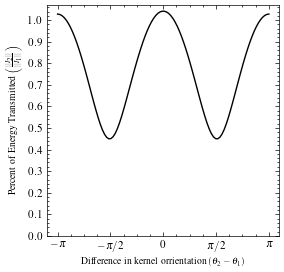

In [150]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2.pdf', dpi=600)
plt.show()


In [151]:
tf.reduce_sum(tf.abs(w))

<tf.Tensor: shape=(), dtype=float64, numpy=2.4494897427831788>

<tf.Tensor: shape=(), dtype=float32, numpy=34.4093>

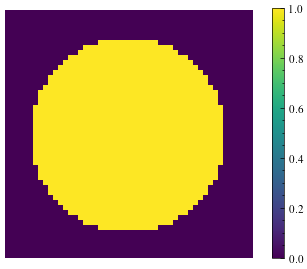

In [152]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)

tf.math.reduce_euclidean_norm(i0)

In [153]:
np.sqrt(2/9)

0.4714045207910317

0.33333333333333337


<tf.Tensor: shape=(), dtype=float32, numpy=9.472182>

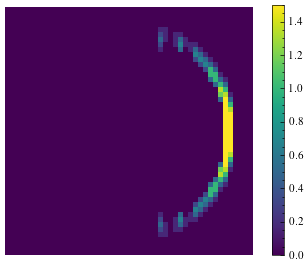

In [154]:
angle = 0

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  
print(np.std(w))

i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 


i1 = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
#plt.title("Conv 1")


tf.math.reduce_euclidean_norm(i1)



In [155]:
3*np.std(w), tf.math.reduce_euclidean_norm(w)

(1.0, <tf.Tensor: shape=(), dtype=float64, numpy=1.0>)

<tf.Tensor: shape=(), dtype=float32, numpy=3.1534817>

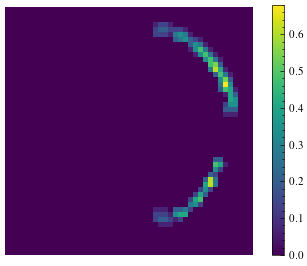

In [156]:
angle = np.pi/2

w = np.zeros((3,3,1,1))
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  



i2_op = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_op[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_y.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
#plt.title("Conv 2")

tf.math.reduce_euclidean_norm(i2_op)


<tf.Tensor: shape=(), dtype=float32, numpy=10.644074>

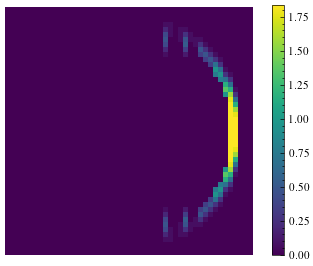

In [157]:
angle = 0
w = np.zeros((3,3,1,1))
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  



i2_same = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_same[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_x.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


tf.math.reduce_euclidean_norm(i2_same)


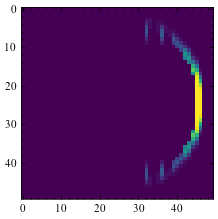

In [158]:
plt.imshow((i2_same - i)[0, ..., 0])